In [1]:
%matplotlib notebook
import numpy as np
import cv2 as cv
from scipy import signal
from numpy import savetxt
import scipy.fft as sfft
import scipy.signal as iir
import matplotlib.pyplot as plt

In [2]:
# Caga Primer Frame del Video
frame = np.loadtxt("FirstFrame.txt",dtype=int)

# Caga Filtro FIR
FIRCoefs = np.loadtxt("FIRCoefs.txt").astype('float32')

In [4]:
b1, a1 = signal.iirnotch(2.0455455455455454, 5.047047047047047, 425*2)
b2, a2 = signal.iirnotch(20.02892892892893,70.63163163163163, 240*2)

def filtradoIIR(img):
    res1 = iir.lfilter(b1,a1,img.flatten()).reshape(480, 848)
    return iir.lfilter(b2,a2,res1.flatten('F')).reshape(848,480).T.astype('uint8')

def filtradoFIR(img): 
    for i in range(480):
        img[i,:] = signal.correlate(img[i,:],FIRCoefs,mode="same")
    return img

def filtradoFFT2D(img):
    img_dft = cv.dft(img.astype('float32'),flags=cv.DFT_COMPLEX_OUTPUT)
    mag_dft, phase_dft = cv.cartToPolar(img_dft[:,:,0],img_dft[:,:,1])
    mag_dft[20,2] = 0
    mag_dft[460,846] = 0
    inv = mag_dft*np.exp(1j*phase_dft)
    img_dft[:,:,0] = np.real(inv)
    img_dft[:,:,1] = np.imag(inv)
    img = cv.idft(img_dft,flags=cv.DFT_REAL_OUTPUT)
    return img

def filtroMediana(frame):
    threshold = 40
    frame = frame.flatten().astype('int16')
    shiftUp= np.roll(frame, -848)
    shiftDown = np.roll(frame, 848)
    shiftLeft= np.roll(frame, -1)
    shiftRight = np.roll(frame, 1)
    resta1 = np.abs(frame - shiftUp)
    resta2 = np.abs(frame - shiftDown)
    resta3 = np.abs(frame - shiftLeft)
    resta4 = np.abs(frame - shiftRight)
    frame = np.where( ((resta1 > threshold) & (resta2 > threshold)) | ((resta3 > threshold) & (resta4 > threshold)) ,(shiftUp+shiftDown+shiftLeft+shiftRight)/4,frame)
    return frame.reshape(480, 848)

In [10]:
#%timeit -n30 -r10 filtradoFIR(frame)
%timeit -n30 -r10 filtradoIIR(frame)
#%timeit -n30 -r10 filtradoFFT2D(frame)
%timeit -n30 -r10 filtroMediana(frame)

print((6.53+4.22)*30)

6.53 ms ± 313 µs per loop (mean ± std. dev. of 10 runs, 30 loops each)
4.22 ms ± 130 µs per loop (mean ± std. dev. of 10 runs, 30 loops each)


<IPython.core.display.Javascript object>


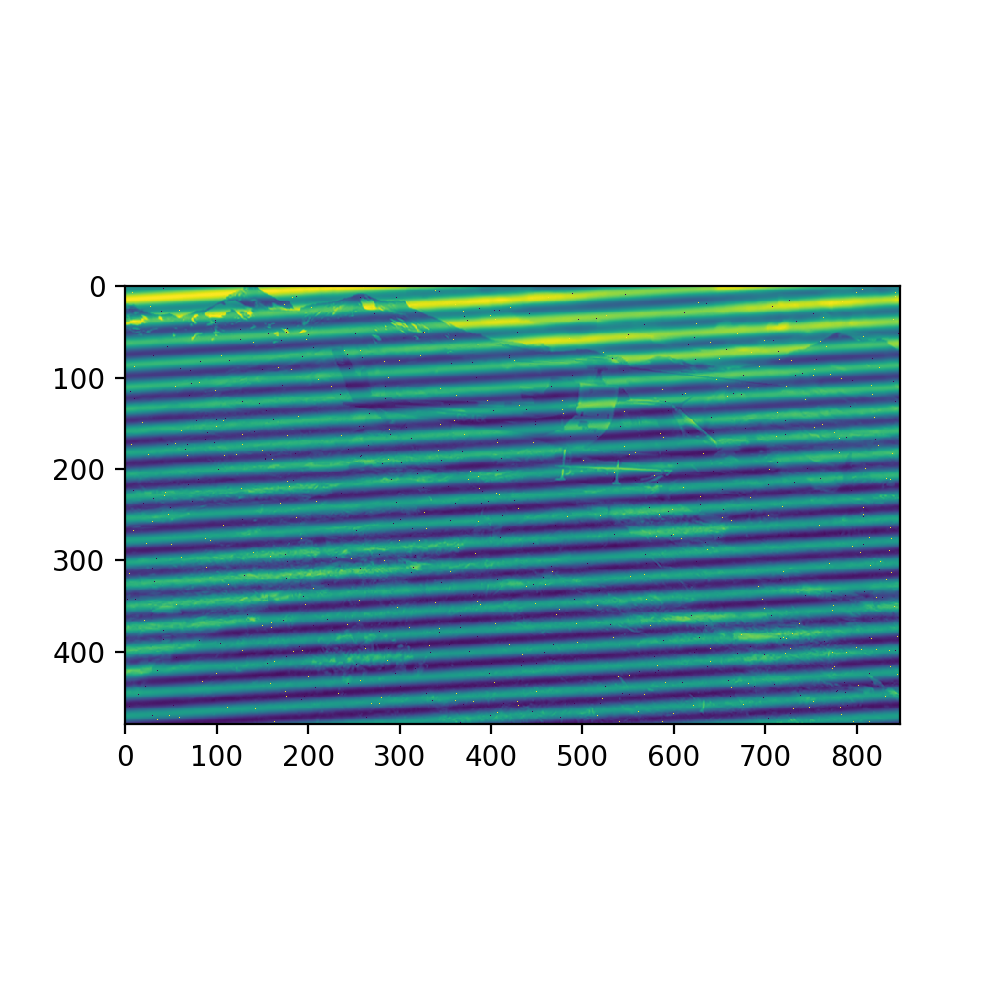

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
copia = frame.copy()

def filtroMediana(copia):
    for x in range(1,847):
        for y in range(1,479):
            if copia[y,x] < 10 or copia[y,x] > 250:
                copia[y,x] = (copia[y+1,x]+copia[y-1,x]+copia[y,x+1]+copia[y,x-1]+copia[y+1,x+1]+copia[y-1,x+1]+copia[y+1,x-1]+copia[y-1,x-1])/8

ax.imshow(copia, interpolation='nearest')

In [32]:
%timeit -n30 -r10 filtroMediana(frame)

357 ms ± 7.17 ms per loop (mean ± std. dev. of 10 runs, 30 loops each)


In [13]:
floatImg = frame.astype("float32")
floatImg.shape

(480, 848)

In [5]:
dft = sfft.fft2(floatImg)
mag = np.abs(dft)
phase = np.angle(dft)

#noiseCoords = np.argwhere(mag > 5000000.0)

#noiseCoords = np.array([[2,20],[846,460]])
#mag[noiseCoords[:,0],noiseCoords[:,1]] = 0
val = mag[21,3]
mag[18,2] = val
mag[19,2] = val

mag[20,2] = val

mag[21,2] = val
mag[22,2] = val

mag[462,846] = val
mag[461,846] = val

mag[460,846] = val

mag[459,846] = val
mag[458,846] = val


logMag = np.log(mag+1)

inverse = np.abs(sfft.ifft2(mag*np.exp(1j*phase)))

cols = len(frame[0,:])
rows = len(frame[:,0])

#for x in range(1,cols-1):
    #for y in range(1,rows-1):
        #if inverse[x,y] > 180 or inverse[x,y] < 80:
            #inverse[x,y] = (inverse[x+1,y]+inverse[x-1,y]+inverse[x,y+1]+inverse[x,y-1]+inverse[x-1,y-1]+inverse[x-1,y+1]+inverse[x+1,y-1]+inverse[x+1,y+1])/8

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(inverse, interpolation='nearest')

NameError: name 'floatImg' is not defined

In [4]:
magAvg = np.zeros(241)
fixed = frame.copy()
for i in range(cols):
    col = frame[:,i]
    fft = sfft.rfft(col)
    phase = np.angle(fft)
    mag = np.abs(fft)
    #mag[20] = 0#(mag[1]+mag[3])/2
    fixed[:,i] = sfft.irfft(mag*np.exp(1j*phase))
    magAvg = magAvg + mag

magAvg = magAvg/cols

t = np.arange(len(magAvg))
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
ax.plot(t, np.log(magAvg+1))

NameError: name 'cols' is not defined

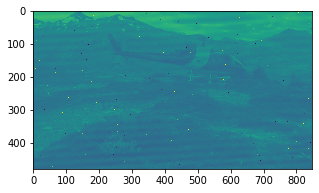

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(fixed, interpolation='nearest')

Rows 480
Cols 848


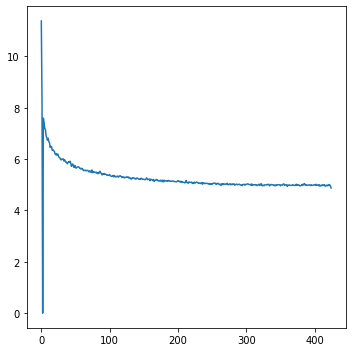

In [10]:
# Filtrado por filas
print("Rows",rows)
print("Cols",cols)
magAvg = np.zeros(425)
fixed = frame.copy()
for i in range(rows):
    row = frame[i,:]
    fft = sfft.rfft(row)
    phase = np.angle(fft)
    mag = np.abs(fft)
    mag[2] = 0
    fixed[i,:] = sfft.irfft(mag*np.exp(1j*phase))
    magAvg = magAvg + mag

magAvg = magAvg/rows

t = np.arange(len(magAvg))
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
ax.plot(t, np.log(magAvg+1))

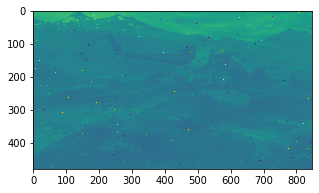

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(fixed, interpolation='nearest')

<IPython.core.display.Javascript object>


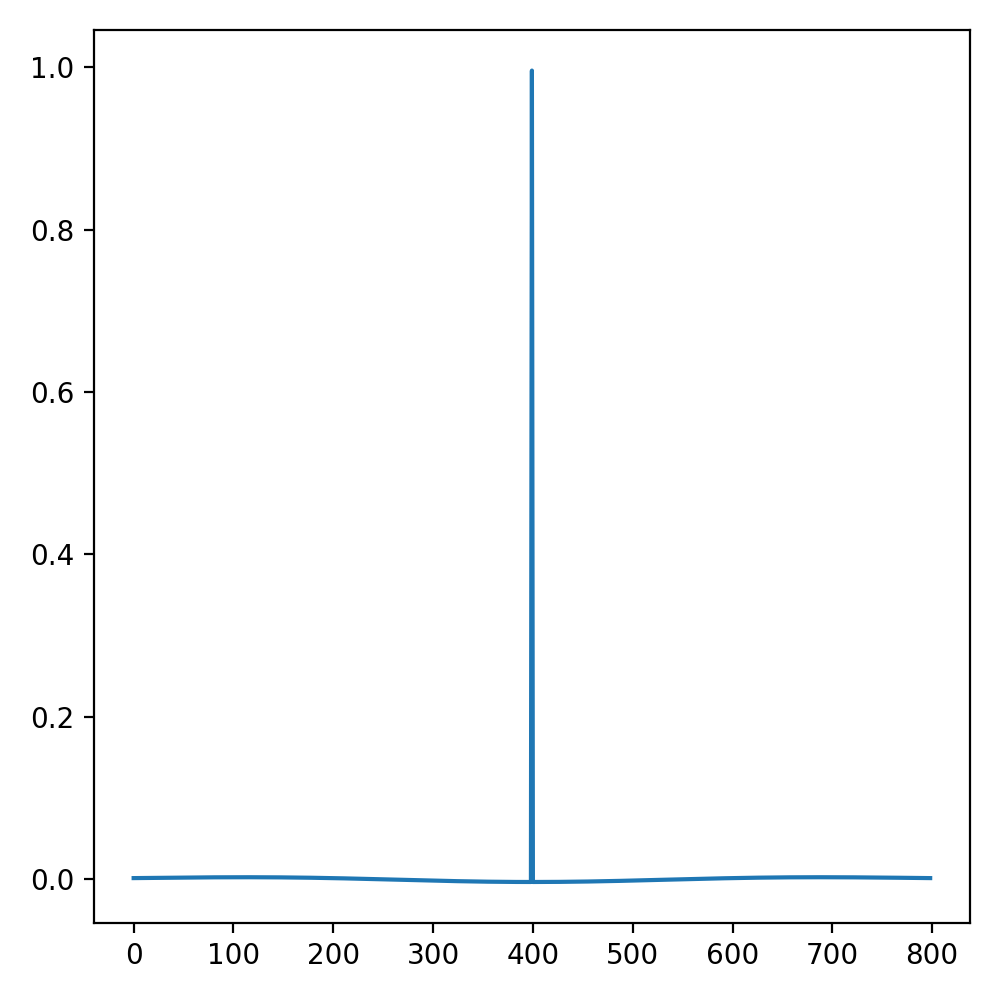

In [145]:
# Filtrado por filas

row = frame.flatten()
fft = sfft.rfft(row)
phase = np.angle(fft)
mag = np.abs(fft)

kk = np.ones(len(mag))
kkk = np.zeros(len(mag))

for i in range(200,1000):
        kk[i] = 0


FIR = sfft.irfft(kk*np.exp(1j*kkk))[0:400]
filt = np.concatenate((FIR[::-1],FIR[1:]))

np.savetxt('ColumnFIR2.txt',filt)

imag = sfft.irfft(mag*np.exp(1j*phase))

t = np.arange(len(filt))
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
ax.plot(t, filt)

NameError: name 'imag' is not defined

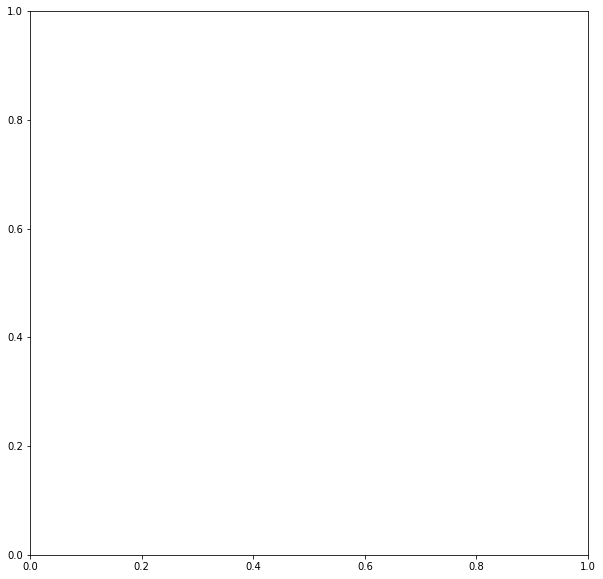

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imag.reshape(480,848), interpolation='nearest')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(frame, interpolation='nearest')

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def plot_func(freq):
    b, a = signal.iirnotch(2, freq, 425*2)
    data = frame.copy().astype('float32')

    data = iir.lfilter(b,a,data.flatten()).reshape(480, 848)
        
        
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(data, interpolation='nearest')

interact(plot_func, freq = widgets.FloatSlider(value=0.1,
                                               min=0.1,
                                               max=5,
                                               step=0.05))







    

interactive(children=(FloatSlider(value=0.1, description='freq', max=5.0, min=0.1, step=0.05), Output()), _dom…

<function __main__.plot_func(freq)>

In [49]:
def findIIR(Q):
    b, a = signal.iirnotch(2.0457957957957955, Q, 425*2)
    data = frame.copy().astype('float32').flatten()
    res = iir.lfilter(b,a,data).reshape(480, 848)
    return ((perfect - res)**2).mean(axis=None)
    

Qs = np.linspace(4, 6, num=1000)
err = 100000000000000
bestQ = 0
for i in Qs:
    ems = findIIR(i)
    if(ems < err):
        err = ems
        bestQ = i

print(err)
print(bestQ)

18.926833302671035
5.047047047047047


In [50]:
b, a = signal.iirnotch(2.0455455455455454, 5.047047047047047, 425*2) 
filtered = iir.lfilter(b,a,frame.copy().flatten()).reshape(480, 848)

In [51]:
def findIIR2(Q):
    b, a = signal.iirnotch(20.02892892892893, Q, 240*2)
    da = filtered.copy().astype('float32').flatten("F")
    res = iir.lfilter(b,a,da).reshape(848,480).T
    return ((perfect - res)**2).mean(axis=None)
    

Qs = np.linspace(70, 71, num=1000)
err = 100000000000000
bestQ = 0
for i in Qs:
    ems = findIIR2(i)
    if(ems < err):
        err = ems
        bestQ = i

print(err)
print(bestQ)

10.604384334077984
70.63163163163163


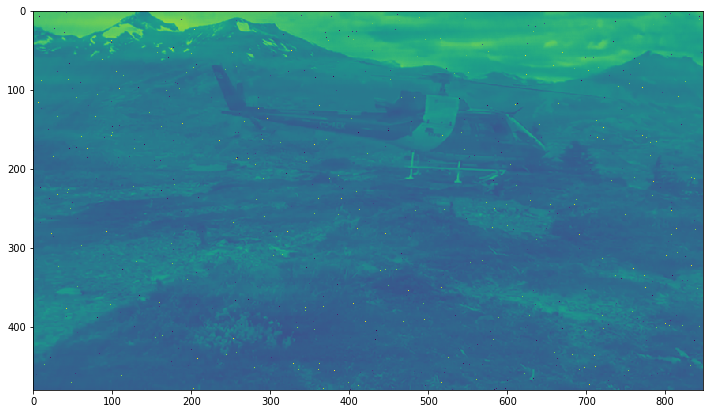

In [53]:
b1, a1 = signal.iirnotch(20.02892892892893,70.63163163163163, 240*2) 
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(iir.lfilter(b1,a1,filtered.copy().flatten("F")).reshape(848,480).T.astype('uint8'), interpolation='nearest')

<IPython.core.display.Javascript object>


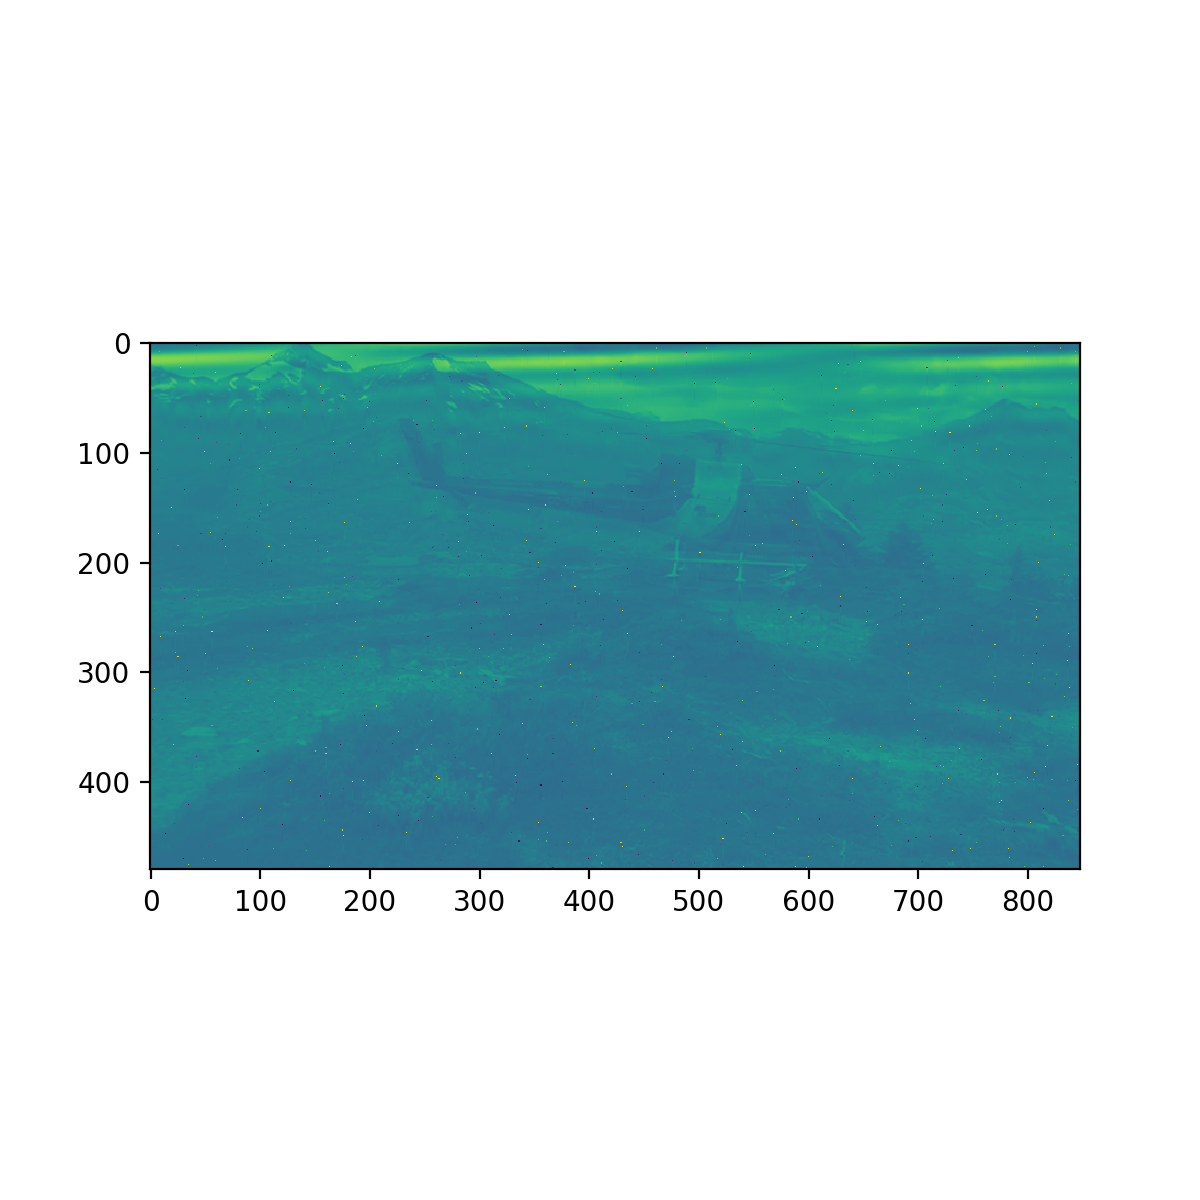

In [600]:
b, a = signal.iirnotch(2, 5, 425*2)
b1, a1 = signal.iirnotch(20, 3, 240*2)
data = frame.copy().astype('float32')

#for i in range(rows):
    #data[i,:] = iir.lfilter(b,a,data[i,:])

for i in range(cols):
    data[:,i] = iir.lfilter(b1,a1,data[:,i])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data, interpolation='nearest')

<IPython.core.display.Javascript object>


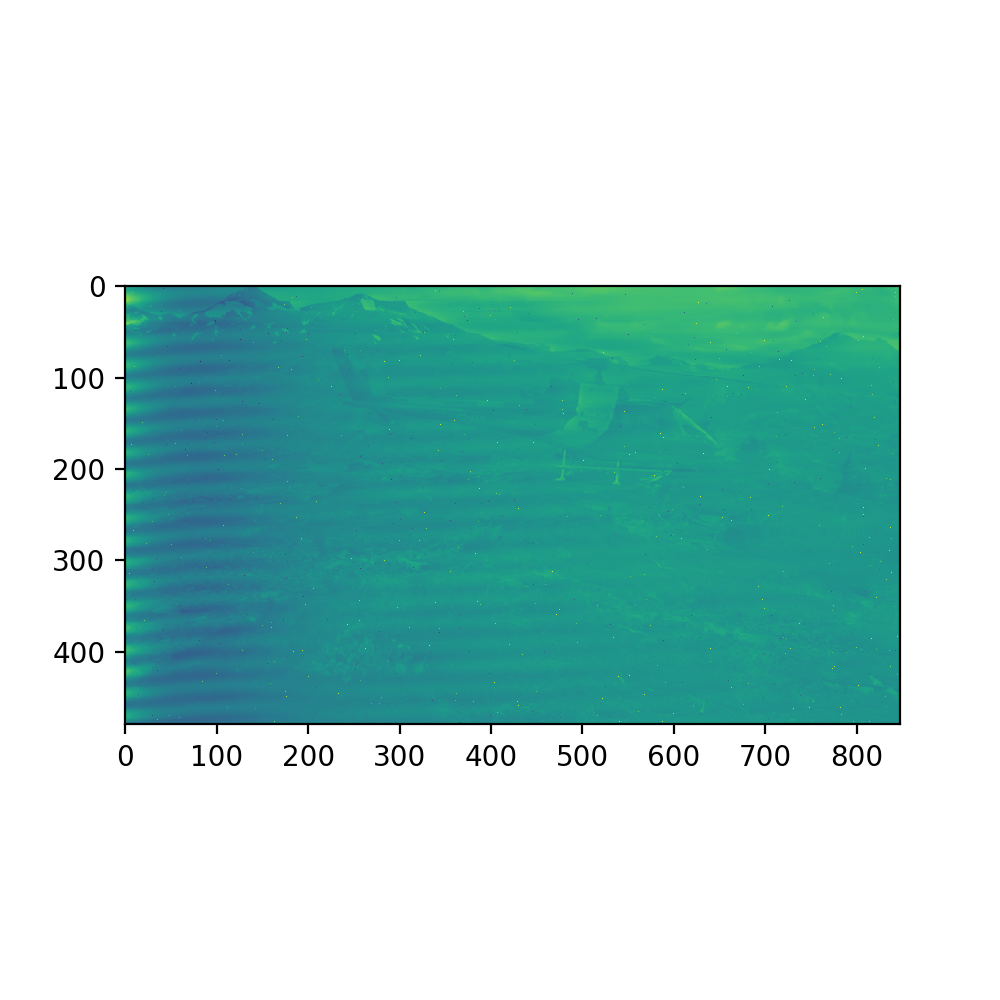

In [98]:


#np.savetxt('ColumnFIR.txt',filt)

#window = signal.hamming(len(filt))
#filt = filt*window
#fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
#t = np.arange(len(filt))
#ax.plot(t, window)
err = 10000000000000000000000000000000
ind = 0
for i in range(3,840):
    filterMag = np.ones(425);
    filterPhase = np.zeros(425);
    filterMag[2] = 0;
    FIR = sfft.irfft(filterMag*np.exp(1j*filterPhase))[:i]
    filt = np.concatenate((FIR[::-1],FIR[1:]))
    #window = signal.hamming(len(filt))
    #filt = filt*window
    data = frame.copy()
    data = signal.correlate(data.flatten(),filt,mode="same",method='direct').reshape(480,848)
    mse = ((perfect - data)**2).mean(axis=None)
    if(mse < err):
        err = mse
        ind = i
    

1983.3288175980174
1965.509357450891
1948.31040349553
1931.737976953058
1915.797318437091
1900.4932158604754
1885.8297258967302
1871.8103124101524
1858.4379220226783
1845.7147803242678
1833.6424377452333
1822.221805693227
1811.4532357569515
1801.336466292092
1791.8706183270385
1783.0541117546875
1774.8848996337617
1767.3602341620222
1760.4768322595514
1754.2307930838701
1748.6176040962723
1743.632158008098
1739.2686677619947
1735.5208643524802
1732.3819111462276
1729.8445105910362
1727.9007767650573
1726.542293772522
1725.7600754388798
1725.5447479600637
1704.810469195558
1682.6722784610743
1660.274509467372
1637.63285803793
1614.7633748952007
1591.682375149469
1568.4064186495218
1544.9522703615035
1521.3369731404562
1497.5777757147553
1473.6922725859306
1449.6980677826095
1425.6130828478556
1401.4552514457976
1377.2427142854704
1352.9937196326323
1328.726687496662
1304.4600379222672
1280.2122538878243
1256.0018305387684
1231.847389278221
1207.7673881702012
1183.7803813466346
1159.9048

425


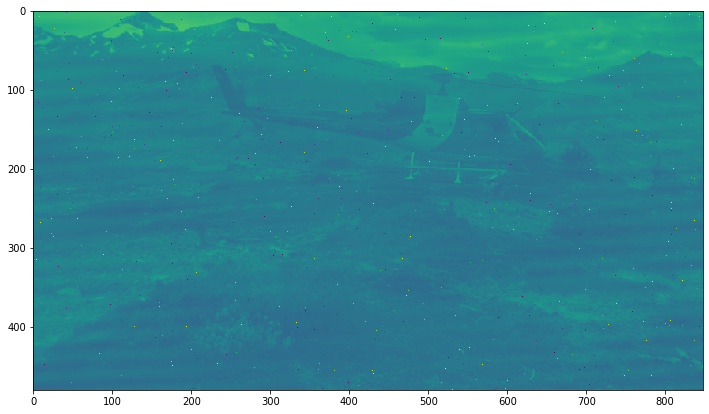

In [100]:
print(ind)
filterMag = np.ones(425);
filterPhase = np.zeros(425);
filterMag[2] = 0;
FIR = sfft.irfft(filterMag*np.exp(1j*filterPhase))[:ind]
filt = np.concatenate((FIR[::-1],FIR[1:]))
np.savetxt('ColumnFIR.txt',filt)
#window = signal.hamming(len(filt))
#filt = filt*window
data = frame.copy()
data = signal.correlate(data.flatten(),filt,mode="same",method='direct').reshape(480,848)
    
#for i in range(rows):
    #data[i,:] = signal.correlate(data[i,:],filt,mode="same")

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(data, interpolation='nearest')

In [280]:
print(len(frame[0,:]))
filterMag = np.ones(241);
filterPhase = np.zeros(241);
filterMag[18] = 0;
filterMag[19] = 0;
filterMag[20] = 0;
filterMag[21] = 0;
filterMag[22] = 0;
FIR = sfft.irfft(filterMag*np.exp(1j*filterPhase))
filt = np.concatenate((FIR[::-1],FIR[1:]))

window = signal.hamming(len(filt))
filt = filt*window
#fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
#t = np.arange(len(filt))
#ax.plot(t, window)

data = frame.copy()
for i in range(rows):
    data[:,i] = signal.correlate(data[:,i],filt,mode="same")




848


<IPython.core.display.Javascript object>


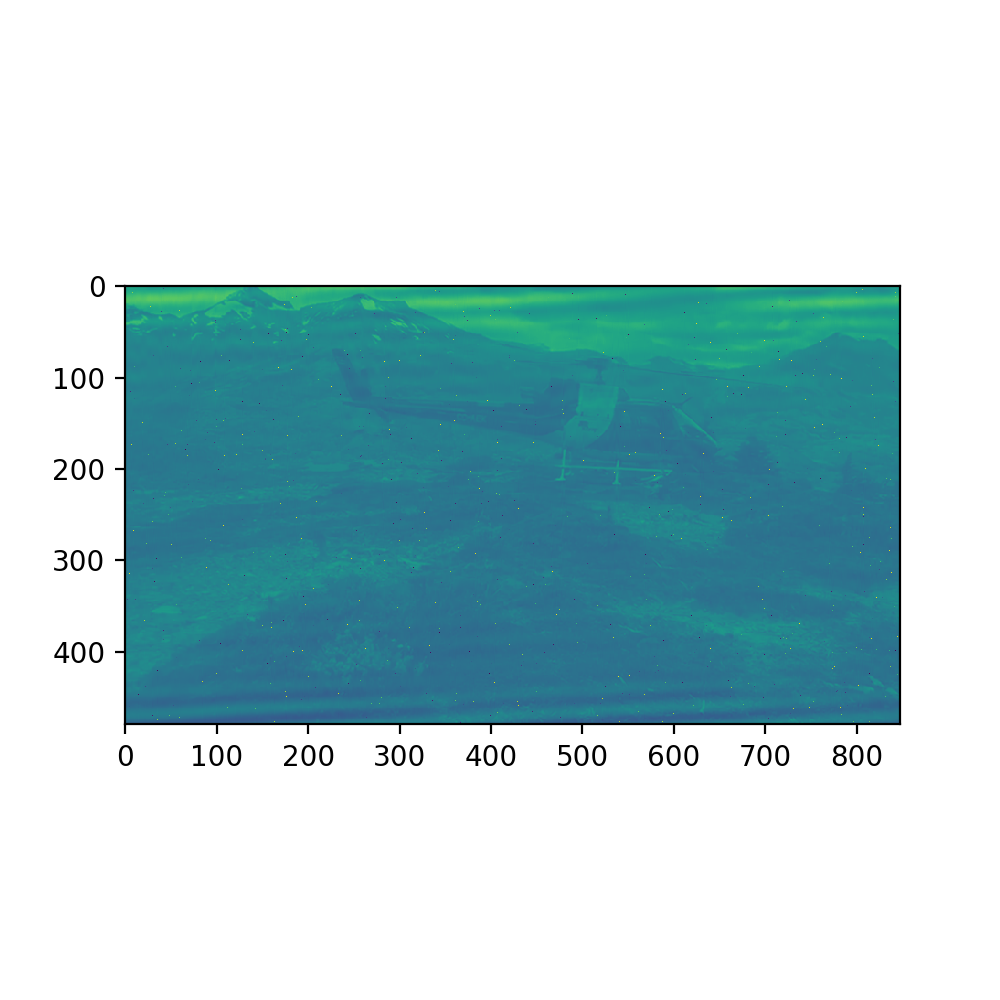

In [281]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data, interpolation='nearest')

In [62]:
a = np.array([[1,2,3],[4,5,6]])
a.flatten('F').reshape(3,2).T

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
# FILTRADO FIR
    #for i in range(480):
        #frame[i,:] = signal.convolve(frame[i,:], FIR, mode="same")
    #cv.imshow("Torres del paine", IIRFilt(frame))
    #cv.waitKey(10)

    # Filtrado IIR
    #b, a = signal.iirnotch(20, 3, 240*2)
    #for i in range(848):
        #frame[:,i] = iir.lfilter(b,a,frame[:,i])

    #frame = filtradoFFT2D(frame)
    #cv.imshow("Torres del paine", frame)
    #cv.waitKey(100)
    #inverse.astype('uint8')
    #frame = signal.correlate(frame.flatten(), FIR, mode="same").astype('uint8').reshape(480, 848)

In [35]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
ind = np.argwhere(a > 5)
ind

a[ind[:,0],ind[:,1]]


array([6, 7, 8, 9])